### Imports and initial config

In [69]:
import numpy as np
from nltk.corpus import wordnet as wn
from stanfordcorenlp import StanfordCoreNLP
import re
import bisect
from collections import defaultdict
import ast
import os
from gutenberg.cleanup import strip_headers
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
import math
import gensim
import pickle
from scipy import spatial
from nltk.tree import *
import nltk.corpus
import nltk.tokenize.punkt
import nltk.stem.snowball
import string

In [4]:
public='/home/users2/mehrotsh/scripts/packages/stanford-corenlp-full-2018-02-27/'
personal='/home/samarth/stanford-corenlp-full-2018-02-27/'

In [6]:
nlp = StanfordCoreNLP(personal)

### Useful Functions

Tree builder

In [7]:
def tree(): 
    return defaultdict(tree)


def _leadingSpaces_(target):
    return len(target) - len(target.lstrip())

def _findParent_(curIndent, parid, treeRef):
    tmpid = parid
    while (curIndent <= treeRef[tmpid]['indent']):
        tmpid = treeRef[tmpid]['parid']
    return tmpid


def generateTree(rawTokens, treeRef):

    # (token
    REGEX_OPEN = r"^\s*\(([a-zA-Z0-9_']*)\s*$"
    # (token (tok1 tok2) (tok3 tok4) .... (tokx toky))
    REGEX_COMP = r"^\s*\(([a-zA-Z0-9_']+)\s*((?:[(]([a-zA-Z0-9_;.,?'!]+)\s*([a-zA-Z0-9_;\.,?!']+)[)]\s*)+)"    
    # (, ,) as stand-alone. Used for match() not search()
    REGEX_PUNC = r"^\s*\([,!?.'\"]\s*[,!?.'\"]\)"
    # (tok1 tok2) as stand-alone
    REGEX_SOLO_PAIR = r"^\s*\(([a-zA-Z0-9_']+)\s*([a-zA-Z0-9_']+)\)"
    # (tok1 tok2) used in search()
    REGEX_ISOL_IN_COMP = r"\(([a-zA-Z0-9_;.,?!']+)\s*([a-zA-Z0-9_;.,?!']+)\)"
    # (punc punc) used in search()
    REGEX_PUNC_SOLO = r"\([,!?.'\"]\s*[,!?.'\"]\)"
   
    treeRef[len(treeRef)] = {'curid':0, 
                             'parid':-1, 
                             'posOrTok':'ROOT', 
                             'indent':0,
                            'children':[],
                            'childrenTok':[]}
    ID_CTR = 1
    
    for tok in rawTokens[1:]:
        
        curIndent = _leadingSpaces_(tok) 
        parid = _findParent_(curIndent, ID_CTR-1, treeRef)
        
        # CHECK FOR COMPOSITE TOKENS
        checkChild = re.match(REGEX_COMP, tok)
        if (checkChild):
            treeRef[ID_CTR] = {'curid':ID_CTR, 
                               'parid':parid, 
                               'posOrTok':checkChild.group(1), 
                               'indent':curIndent,
                              'children':[],
                              'childrenTok':[]}
            upCTR = ID_CTR
            ID_CTR += 1
            
            subCheck = re.sub(REGEX_PUNC_SOLO,'',checkChild.group(2))
            subs = re.findall(REGEX_ISOL_IN_COMP, subCheck) 
            for ch in subs:
                treeRef[ID_CTR] = {'curid':ID_CTR, 
                                   'parid':upCTR, 
                                   'posOrTok':ch[0], 
                                   'indent':curIndent+2,
                                  'children':[],
                                  'childrenTok':[]}
                ID_CTR += 1
                treeRef[ID_CTR] = {'curid':ID_CTR, 
                                   'parid':ID_CTR-1, 
                                   'posOrTok':ch[1], 
                                   'indent':curIndent+2,
                                  'children':[],
                                  'childrenTok':[]}
                ID_CTR += 1
            continue
           

            
        checkSingle = re.match(REGEX_SOLO_PAIR, tok)
        if (checkSingle):
            treeRef[ID_CTR] = {'curid':ID_CTR, 
                               'parid':parid, 
                               'posOrTok':checkSingle.group(1), 
                               'indent':curIndent+2,
                              'children':[],
                              'childrenTok':[]}
            ID_CTR += 1
            treeRef[ID_CTR] = {'curid':ID_CTR, 
                               'parid':ID_CTR-1, 
                               'posOrTok':checkSingle.group(2), 
                               'indent':curIndent+2,
                              'children':[],
                              'childrenTok':[]}
            ID_CTR += 1
            continue
        
        
        checkPunc = re.match(REGEX_PUNC, tok)
        if (checkPunc): # ignore punctuation
            continue

        checkMatch = re.match(REGEX_OPEN, tok)
        if (checkMatch):
            treeRef[ID_CTR] = {'curid':ID_CTR, 
                               'parid':parid, 
                               'posOrTok':checkMatch.group(1), 
                               'indent':curIndent,
                              'children':[],
                              'childrenTok':[]}
            ID_CTR += 1
            continue

    return
            

def flipTree(treeRef):
    # Pass 1 fill in children
    for k,v in treeRef.items():
        if (k > 0):
            bisect.insort(treeRef[v['parid']]['children'], k)
    # Pass 2 map children to tokens
    for k,v in treeRef.items():
        if (k > 0):
            treeRef[k]['childrenTok'] = [treeRef[ch]['posOrTok'] for ch in treeRef[k]['children']]
    treeRef[0]['childrenTok'] = treeRef[1]['posOrTok']


Kernel methods

In [8]:
def _isLeaf_(tree, parentNode):
    return (len(tree[parentNode]['children']) == 0)

def _isPreterminal_(tree, parentNode):
    for idx in tree[parentNode]['children']:
        if not _isLeaf_(tree, idx):
            return False
    return True

'''
Implementation of the Colins-Duffy or Subset-Tree (SST) Kernel
'''

def _cdHelper_(tree1, tree2, node1, node2, store, lam, SST_ON):
    # No duplicate computations
    if store[node1, node2] >= 0:
        return

    # Leaves yield similarity score by definition
    if (_isLeaf_(tree1, node1) or _isLeaf_(tree2, node2)):
        store[node1, node2] = 0
        return

    # same parent node
    if tree1[node1]['posOrTok'] == tree2[node2]['posOrTok']:
        # same children tokens
        if tree1[node1]['childrenTok'] == tree2[node2]['childrenTok']:
            # Check if both nodes are pre-terminal
            if _isPreterminal_(tree1, node1) and _isPreterminal_(tree2, node2):
                store[node1, node2] = lam
                return
            # Not pre-terminal. Recurse among the children of both token trees.
            else:
                nChildren = len(tree1[node1]['children'])

                runningTotal = None
                for idx in range(nChildren):
                     # index ->  node_id
                    tmp_n1 = tree1[node1]['children'][idx]
                    tmp_n2 = tree2[node2]['children'][idx]
                    # Recursively run helper
                    _cdHelper_(tree1, tree2, tmp_n1, tmp_n2, store, lam, SST_ON)
                    # Set the initial value for the layer. Else multiplicative product.
                    if (runningTotal == None):
                        runningTotal = SST_ON + store[tmp_n1, tmp_n2]
                    else:
                        runningTotal *= (SST_ON + store[tmp_n1, tmp_n2])

                store[node1, node2] = lam * runningTotal
                return
        else:
            store[node1, node2] = 0
    else: # parent nodes are different
        store[node1, node2] = 0
        return


def _cdKernel_(tree1, tree2, lam, SST_ON):
    # Fill the initial state of the store
    store = np.empty((len(tree1), len(tree2)))
    store.fill(-1)
    # O(N^2) to compute the tree dot product
    for i in range(len(tree1)):
        for j in range(len(tree2)):
            _cdHelper_(tree1, tree2, i, j, store, lam, SST_ON)

    return store.sum()

'''
Returns a tuple w/ format: (raw, normalized)
If NORMALIZE_FLAG set to False, tuple[1] = -1
'''
def CollinsDuffy(tree1, tree2, lam, NORMALIZE_FLAG, SST_ON):
    raw_score = _cdKernel_(tree1, tree2, lam, SST_ON)
    if (NORMALIZE_FLAG):
        t1_score = _cdKernel_(tree1, tree1, lam, SST_ON)
        t2_score = _cdKernel_(tree2, tree2, lam, SST_ON)
        return (raw_score,(raw_score / math.sqrt(t1_score * t2_score)))
    else:
        return (raw_score,-1)



'''
Implementation of the Partial Tree (PT) Kernel from:
"Efficient Convolution Kernels for Dependency and Constituent Syntactic Trees"
by Alessandro Moschitti
'''

'''
The delta function is stolen from the Collins-Duffy kernel
'''

def _deltaP_(tree1, tree2, seq1, seq2, store, lam, mu, p):

#     # Enumerate subsequences of length p+1 for each child set
    if p == 0:
        return 0
    else:
        # generate delta(a,b)
        _delta_(tree1, tree2, seq1[-1], seq2[-1], store, lam, mu)
        if store[seq1[-1], seq2[-1]] == 0:
            return 0
        else:
            runningTot = 0
            for i in range(p-1, len(seq1)-1):
                for r in range(p-1, len(seq2)-1):
                    scaleFactor = pow(lam, len(seq1[:-1])-i+len(seq2[:-1])-r)
                    dp = _deltaP_(tree1, tree2, seq1[:i], seq2[:r], store, lam, mu, p-1)
                    runningTot += (scaleFactor * dp)
            return runningTot

def _delta_(tree1, tree2, node1, node2, store, lam, mu):

    # No duplicate computations
    if store[node1, node2] >= 0:
        return

    # Leaves yield similarity score by definition
    if (_isLeaf_(tree1, node1) or _isLeaf_(tree2, node2)):
        store[node1, node2] = 0
        return

    # same parent node
    if tree1[node1]['posOrTok'] == tree2[node2]['posOrTok']:

        if _isPreterminal_(tree1, node1) and _isPreterminal_(tree2, node2):
            if tree1[node1]['childrenTok'] == tree2[node2]['childrenTok']:
                store[node1, node2] = lam
            else:
                store[node1, node2] = 0
            return

        else:
            # establishes p_max
            childmin = min(len(tree1[node1]['children']), len(tree2[node2]['children']))
            deltaTot = 0
            for p in range(1,childmin+1):
                # compute delta_p
                deltaTot += _deltaP_(tree1, tree2,
                                     tree1[node1]['children'],
                                     tree2[node2]['children'], store, lam, mu, p)

            store[node1, node2] = mu * (pow(lam,2) + deltaTot)
            return

    else:
        # parent nodes are different
        store[node1, node2] = 0
        return

def _ptKernel_(tree1, tree2, lam, mu):
    # Fill the initial state of the store
    store = np.empty((len(tree1), len(tree2)))
    store.fill(-1)

    # O(N^2) to compute the tree dot product
    for i in range(len(tree1)):
        for j in range(len(tree2)):
            _delta_(tree1, tree2, i, j, store, lam, mu)

    return store.sum()

'''
Returns a tuple w/ format: (raw, normalized)
If NORMALIZE_FLAG set to False, tuple[1] = -1
'''
def MoschittiPT(tree1, tree2, lam, mu, NORMALIZE_FLAG):
    raw_score = _ptKernel_(tree1, tree2, lam, mu)
    if (NORMALIZE_FLAG):
        t1_score = _ptKernel_(tree1, tree1, lam, mu)
        t2_score = _ptKernel_(tree2, tree2, lam, mu)
        return (raw_score,(raw_score / math.sqrt(t1_score * t2_score)))
    else:
        return (raw_score,-1)

In [9]:
def getNLPToks(rawSentence):
    output = nlp.annotate(rawSentence, properties={'annotators': 'tokenize,ssplit,pos,parse','outputFormat': 'json','timeout':'50000'})
    output=ast.literal_eval(output)
    tokens = output['sentences'][0]['tokens']
    parse = output['sentences'][0]['parse'].split("\n")
    return {
        'toks':tokens, 'parse':parse
    }

In [10]:
def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [11]:
def getDuffyScore(sent1,sent2):
    tree_1=tree()
    tree_2=tree()
    out1=getNLPToks(sent1)
    out2=getNLPToks(sent2)
    generateTree(out1['parse'],tree_1)
    generateTree(out2['parse'],tree_2)
    flipTree(tree_1)
    flipTree(tree_2)
    (rscore_st, nscore_st) = CollinsDuffy(tree_1, tree_2, 0.8, 1, 1)
    return rscore_st,nscore_st

In [12]:
def getMoschittiScore(sent1,sent2):
    tree_1=tree()
    tree_2=tree()
    out1=getNLPToks(sent1)
    out2=getNLPToks(sent2)
    generateTree(out1['parse'],tree_1)
    generateTree(out2['parse'],tree_2)
    flipTree(tree_1)
    flipTree(tree_2)
    (rscore_st, nscore_st) = MoschittiPT(tree_1, tree_2, 0.8, 1, 1)
#     return rscore_st,nscore_st
    return nscore_st

### Testing on Project Gutenberg samples

Creating parse trees for the new text

In [ ]:
test="./new/pierre.txt"
testB=open(test)
raw=testB.read()
text = strip_headers(raw).strip()
text=text.replace('\n',' ')
text=sent_tokenize(text)
text = list(filter(lambda x: len(x)>1, text))

In [ ]:
len(text)

In [ ]:
i=0
parseTrees=list()
for sent in text:
    print(i)
    sentParse=getNLPToks(sent)
    tempTree=tree()
    generateTree(sentParse['parse'],tempTree)
    flipTree(tempTree)
    parseTrees.append(tempTree)
    i=i+1

In [ ]:
len(parseTrees)

Loading candidates and creating parse trees

In [7]:
potential="./potential/"

In [ ]:
potentialParseTrees=dict()

In [ ]:
for file in os.listdir(potential):
    print(file)
    candidate=open(potential+file)
    rawtext=candidate.read()
    rawtext = strip_headers(rawtext).strip()
    candidate=rawtext.replace('\n',' ')
    candidate=sent_tokenize(candidate)
    candidate = list(filter(lambda x: len(x)>1, candidate))
    pTrees=list()
    for sent in candidate:
        sentParse=getNLPToks(sent)
        tempTree=tree()
        generateTree(sentParse['parse'],tempTree)
        flipTree(tempTree)
        pTrees.append(tempTree)
    potentialParseTrees[file]=pTrees
    
    

In [ ]:
allScores=list()
i=0
for tr in parseTrees:
#     print(i)
    if i%10==0:
        print(i)
    sentScoreDict=dict()
    for file in os.listdir(potential):
#         print(file)
        bookTrees=potentialParseTrees[file]
        df=list()
        for bTree in bookTrees:
            (rscore_st, nscore_st) = MoschittiPT(tr, bTree, 0.8, 1, 1)
            df.append(nscore_st)
#         print(df)
        sentScoreDict[file]=df
    allScores.append(sentScoreDict)
#     print('over')
    i=i+1
            

In [ ]:
len(allScores)

In [ ]:
text[174]

In [ ]:
allScores=allScores[:-1]

In [ ]:
books=dict()
for file in os.listdir(potential):
    print(file)
    candidate=open(potential+file)
    rawtext=candidate.read()
    rawtext = strip_headers(rawtext).strip()
    candidate=rawtext.replace('\n',' ')
    candidate=sent_tokenize(candidate)
    candidate = list(filter(lambda x: len(x)>1, candidate))
    books[file]=candidate

In [ ]:
for i in range(60,70):
    print('Sentence',i)
    print('Original Sent',text[i])
    for book in os.listdir(potential):
        print(book)
        maxIndex=allScores[i][book].index(max(allScores[i][book]))
        print('Score',allScores[i][book][maxIndex])
        print('Similar sentence:',books[book][maxIndex])
    print('\n\n')

In [ ]:
allScores[600]['2.txt'].index(max(allScores[600]['2.txt']))

In [ ]:
len(allScores)

In [ ]:
len(allScores[0]['5.txt'])

In [ ]:
scoreTuples=list()

In [ ]:
for i in range(len(allScores)):
    scoreTuple=(0,0,0,0)
    for fl in os.listdir(potential):
        scores=allScores[i][fl]
        for j in range(len(scores)):
            scoreTuples.append((i,fl,j,scores[j]))

In [ ]:
len(scoreTuples)

In [ ]:
scoreTuples.sort(key=lambda tup: tup[3],reverse=True)

In [ ]:
print(scoreTuples[0:100])

### Testing on Bible sentences

Two related sentences - high score

In [9]:
sent1='Behold, a virgin shall conceive and bear a son, and his name shall be called Emmanuel'

In [10]:
sent2='behold, a virgin shall conceive in the womb, and shall bring forth a son, and thou shalt call his name Emmanuel.'

In [11]:
getMoschittiScore(sent1,sent2)

0.90231868985626051

Two related sentences - high score

In [12]:
sent3='And thou, Bethlehem, in the land of Juda, art not the least among the princes of Juda: for out of thee shall come a Governor, that shall rule my people Israel'

In [13]:
sent4='And thou, Bethleem, house of Ephratha, art few in number to be reckoned among the thousands of Juda; yet out of thee shall one come forth to me, to be a ruler of Israel'

In [14]:
getMoschittiScore(sent3,sent4)

0.93671489621861459

Two sentences that are not highly related, not such a high score

In [16]:
getMoschittiScore(sent1,sent3)

0.65386364458884894

Similar sentences

In [17]:
sent5='In Rama was there a voice heard, lamentation, and weeping, and great mourning, Rachel weeping for her children, and would not be comforted because they are not.'

In [18]:
sent6='A voice was heard in Rama, of lamentation, and of weeping, and wailing; Rachel would not cease weeping for her children, because they are not.'

In [19]:
getMoschittiScore(sent5,sent6)

0.87978779877927293

Not very similar

In [20]:
getMoschittiScore(sent5,sent3)

0.68938859080577475

Similar Sentences

In [24]:
sent7=' Then saith Jesus unto them, All ye shall be offended because of me this night: for it is written, I will smite the shepherd, and the sheep of the flock shall be scattered abroad.'

In [25]:
sent8='Awake, O sword, against my shepherds, and against the man who is my citizen, saith the Lord Almighty: smite the shepherds, and draw out the sheep: and I will bring mine hand upon the little ones'

In [26]:
getMoschittiScore(sent7,sent8)

0.86443556016593959

Not very similar but still a reasonably high score (False positive), might be a parsing error

In [28]:
getMoschittiScore(sent7,sent3)

0.79324678818767691

Similar sentences

In [33]:
sent9='Jesus said unto him, Thou shalt love the Lord thy God with all thy heart, and with all thy soul, and with all thy mind.'

In [34]:
sent10='And thou shalt love the Lord thy God with all thy mind, and with all thy soul, and all thy strength'

In [35]:
getMoschittiScore(sent9,sent10)

0.93498567308925917

Not similar

In [37]:
getMoschittiScore(sent9,sent1)

0.65811851800780774

### Testing on chunks of the bible 

In [18]:
potential="./potential/"
booksList=os.listdir(potential)

In [13]:
test="./new/matthew"
testB=open(test)
raw=testB.read()
text = strip_headers(raw).strip()
text=text.replace('\n',' ')
text=text.replace(':','. ')
text=sent_tokenize(text)
text = list(filter(lambda x: len(x)>5, text))

In [47]:
i=0
parseTrees=list()
for sent in text:
    print(i)
    sentParse=getNLPToks(sent)
    tempTree=tree()
    generateTree(sentParse['parse'],tempTree)
    flipTree(tempTree)
    parseTrees.append(tempTree)
    i=i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192


In [100]:
pickling_on = open("./tempOutput/parseTrees.pickle","wb")
pickle.dump(parseTrees, pickling_on)

In [48]:
potential="./potential/"

In [50]:
potentialParseTrees=dict()

In [51]:
for file in os.listdir(potential):
    print(file)
    candidate=open(potential+file)
    rawtext=candidate.read()
    rawtext = strip_headers(rawtext).strip()
    candidate=rawtext.replace('\n',' ')
    candidate=rawtext.replace(':','. ')
    candidate=sent_tokenize(candidate)
    candidate = list(filter(lambda x: len(x)>5, candidate))
    pTrees=list()
    for sent in candidate:
        sentParse=getNLPToks(sent)
        tempTree=tree()
        generateTree(sentParse['parse'],tempTree)
        flipTree(tempTree)
        pTrees.append(tempTree)
    potentialParseTrees[file]=pTrees
    

isaiah.txt
micah.txt


In [101]:
pickling_on = open("./tempOutput/potentialParseTrees.pickle","wb")
pickle.dump(potentialParseTrees, pickling_on)

In [52]:
allScores=list()
i=0
for tr in parseTrees:
#     print(i)
    if i%10==0:
        print(i)
    sentScoreDict=dict()
    for file in os.listdir(potential):
#         print(file)
        bookTrees=potentialParseTrees[file]
        df=list()
        for bTree in bookTrees:
            (rscore_st, nscore_st) = MoschittiPT(tr, bTree, 0.8, 1, 1)
            df.append(nscore_st)
#         print(df)
        sentScoreDict[file]=df
    allScores.append(sentScoreDict)
#     print('over')
    i=i+1
            

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [102]:
pickling_on = open("./tempOutput/allScores.pickle","wb")
pickle.dump(allScores, pickling_on)

In [14]:
pickle_off = open("./tempOutput/allScores.pickle","rb")
allScores = pickle.load(pickle_off)

In [15]:
books=dict()
for file in os.listdir(potential):
    print(file)
    candidate=open(potential+file)
    rawtext=candidate.read()
    rawtext = strip_headers(rawtext).strip()
    candidate=rawtext.replace('\n',' ')
    candidate=rawtext.replace(':','. ')
    candidate=sent_tokenize(candidate)
    candidate = list(filter(lambda x: len(x)>5, candidate))
    books[file]=candidate

isaiah.txt
micah.txt


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) 

In [ ]:
index2word_set = set(model.wv.index2word)

In [16]:
scoreTuples=list()

In [20]:
for i in range(len(allScores)):
    scoreTuple=(0,0,0,0)
    s1v=avg_feature_vector(text[i],model,300,index2word_set)
    for fl in os.listdir(potential):
        scores=allScores[i][fl]
        for j in range(len(scores)):
            s2v=avg_feature_vector(books[fl][j],model,300,index2word_set)
            semanticScore=1 - spatial.distance.cosine(s1v, s2v)
            scoreTuples.append((i,fl,j,scores[j],semanticScore,(scores[j]+semanticScore)/2))

/usr/lib64/python3.6/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [21]:
len(scoreTuples)

140504

In [22]:
scoreTuples.sort(key=lambda tup: tup[5],reverse=True)

In [23]:
scoreTuples[0:10]

[(99,
  'micah.txt',
  91,
  0.8762579290517688,
  0.90674972534179688,
  0.89150382719678278),
 (96,
  'isaiah.txt',
  228,
  0.92158759035369442,
  0.8383827805519104,
  0.87998518545280247),
 (21,
  'isaiah.txt',
  270,
  0.90639150246639377,
  0.84649938344955444,
  0.87644544295797411),
 (21,
  'micah.txt',
  52,
  0.89984788878418975,
  0.84785234928131104,
  0.87385011903275034),
 (21,
  'micah.txt',
  129,
  0.89951541752032949,
  0.84728765487670898,
  0.87340153619851923),
 (156,
  'micah.txt',
  74,
  0.90657272704207958,
  0.838206946849823,
  0.87238983694595129),
 (21,
  'micah.txt',
  182,
  0.90725018359973664,
  0.83577513694763184,
  0.87151266027368424),
 (51,
  'isaiah.txt',
  361,
  0.88115923772555071,
  0.86115968227386475,
  0.87115945999970767),
 (21,
  'isaiah.txt',
  173,
  0.90083547093605454,
  0.83656942844390869,
  0.86870244968998156),
 (46,
  'isaiah.txt',
  52,
  0.8981454293009028,
  0.8379817008972168,
  0.8680635650990598)]

In [24]:
for t in scoreTuples[0:10]:
    print('Original Sentence: ',text[t[0]])
    print('Similar Sentence is from: ',t[1])
    print('Score: ',t[3])
    print(books[t[1]][t[2]])
    print('\n\n')

Original Sentence:  for it is written, Thou shalt worship the Lord thy God, and him only shalt thou serve.
Similar Sentence is from:  micah.txt
Score:  0.876257929052
for now shalt thou go forth out of the city, and
thou shalt dwell in the field, and thou shalt go even to Babylon;
there shalt thou be delivered; there the LORD shall redeem thee from
the hand of thine enemies.



Original Sentence:  8 Again, the devil taketh him up into an exceeding high mountain, and sheweth him all the kingdoms of the world, and the glory of them; 4.
Similar Sentence is from:  isaiah.txt
Score:  0.921587590354
7 Now therefore, behold, the Lord bringeth
up upon them the waters of the river, strong and many, even the king
of Assyria, and all his glory.



Original Sentence:  20 But while he thought on these things, behold, the angel of the LORD appeared unto him in a dream, saying, Joseph, thou son of David, fear not to take unto thee Mary thy wife.
Similar Sentence is from:  isaiah.txt
Score:  0.9063915

### New approach: Semantic filtering using TFIDF before parsing and final semantic filtering

In [45]:
potential="./potential/"
booksList=os.listdir(potential)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
test="./new/matthew"
testB=open(test)
raw=testB.read()
text = strip_headers(raw).strip()
text=text.replace('\n',' ')
text=text.replace(':','. ')
text=sent_tokenize(text)
text = list(filter(lambda x: len(x)>5, text))

In [48]:
books=dict()
for file in booksList:
    print(file)
    candidate=open(potential+file)
    rawtext=candidate.read()
    rawtext = strip_headers(rawtext).strip()
    candidate=rawtext.replace('\n',' ')
    candidate=rawtext.replace(':','. ')
    candidate=sent_tokenize(candidate)
    candidate = list(filter(lambda x: len(x)>5, candidate))
    books[file]=candidate

isaiah.txt
micah.txt


TF-IDF based filtering

In [49]:
corpus=[]
corpus=corpus+text
for fl in os.listdir(potential):
    corpus=corpus+books[fl]

In [50]:
vectorizer = TfidfVectorizer(min_df=1)

In [51]:
X = vectorizer.fit_transform(corpus)

In [52]:
X.shape

(921, 2171)

In [53]:
tfIDFScores=[]
for i in range(len(text)):
    scoresDict={}
    j=len(text)
    for fl in booksList:
        bookScore=[]
        for k in range(len(books[fl])):
#             print(k)
            j=len(text)+k
#             print(j)
            simScore=1-spatial.distance.cosine(X[i].toarray(), X[j].toarray())
            bookScore.append((simScore,k))
        scoresDict[fl]=bookScore
    tfIDFScores.append(scoresDict)
        


In [54]:
for sent in tfIDFScores:
    for book in booksList:
        sent[book]=list(filter(lambda tup: tup[0]>0.2,sent[book]))

In [55]:
reducedSentences=dict()
for book in booksList:
    reducedSentences[book]=list()

In [56]:
for sent in tfIDFScores:
    for book in booksList:
        reducedSentences[book]=reducedSentences[book]+[x[1] for x in sent[book]]

In [57]:
for book in booksList:
    reducedSentences[book]=list(set(reducedSentences[book]))

In [59]:
len(reducedSentences['isaiah.txt'])

268

In [60]:
reducedBooks=dict()
for book in booksList:
    reducedBooks[book]=list()

In [61]:
for book in booksList:
    for sent in reducedSentences[book]:
        reducedBooks[book].append(books[book][sent])

In [62]:
test="./new/matthew"
testB=open(test)
raw=testB.read()
text = strip_headers(raw).strip()
text=text.replace('\n',' ')
text=text.replace(':','. ')
text=sent_tokenize(text)
text = list(filter(lambda x: len(x)>5, text))

In [ ]:
i=0
parseTrees=list()
for sent in text:
    print(i)
    sentParse=getNLPToks(sent)
    tempTree=tree()
    generateTree(sentParse['parse'],tempTree)
    flipTree(tempTree)
    parseTrees.append(tempTree)
    i=i+1

In [64]:
pickle_off = open("./tempOutput/parseTrees.pickle","rb")
parseTrees = pickle.load(pickle_off)

In [65]:
potentialParseTrees=dict()

In [166]:
len(books['isaiah.txt'])

545

In [165]:
len(reducedBooks['isaiah.txt'])

268

In [69]:
for book in booksList:
    print(book)
    candidate=reducedBooks[book]
    pTrees=list()
    for sent in candidate:
        sentParse=getNLPToks(sent)
        tempTree=tree()
        generateTree(sentParse['parse'],tempTree)
        flipTree(tempTree)
        pTrees.append(tempTree)
    potentialParseTrees[book]=pTrees
    

isaiah.txt
micah.txt


In [70]:
allScores=list()
i=0
for tr in parseTrees:
#     print(i)
    if i%10==0:
        print(i)
    sentScoreDict=dict()
    for book in booksList:
#         print(file)
        bookTrees=potentialParseTrees[book]
        df=list()
        for bTree in bookTrees:
            (rscore_st, nscore_st) = MoschittiPT(tr, bTree, 0.8, 1, 1)
            df.append(nscore_st)
#         print(df)
        sentScoreDict[book]=df
    allScores.append(sentScoreDict)
#     print('over')
    i=i+1
            

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [35]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) 
index2word_set = set(model.wv.index2word)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [167]:
scoreTuples=list()

In [168]:
for i in range(len(allScores)):
    s1v=avg_feature_vector(text[i],model,300,index2word_set)
    for fl in booksList:
        scores=allScores[i][fl]
        for j in range(len(scores)):
            s2v=avg_feature_vector(reducedBooks[fl][j],model,300,index2word_set)
            semanticScore=1 - spatial.distance.cosine(s1v, s2v)
            scoreTuples.append((i,fl,j,scores[j],semanticScore,(scores[j]+semanticScore)/2))

In [169]:
scoreTuples.sort(key=lambda tup: tup[5],reverse=True)

In [170]:
for t in scoreTuples[0:10]:
    print('Original Sentence: ',text[t[0]])
    print('Similar Sentence is from: ',t[1])
    print('Syntactic Score: ',t[3])
    print('Semantic Score: ',t[4])
    print(reducedBooks[t[1]][t[2]])
    print('\n\n')

Original Sentence:  23 Behold, a virgin shall be with child, and shall bring forth a son, and they shall call his name Emmanuel, which being interpreted is, God with us.
Similar Sentence is from:  isaiah.txt
Syntactic Score:  0.911016855099
Semantic Score:  0.88051789999
14 Therefore
the Lord himself shall give you a sign; Behold, a virgin shall
conceive, and bear a son, and shall call his name Immanuel.



Original Sentence:  19 Whosoever therefore shall break one of these least commandments, and shall teach men so, he shall be called the least in the kingdom of heaven.
Similar Sentence is from:  isaiah.txt
Syntactic Score:  0.892606241371
Semantic Score:  0.879956662655
2 And it shall come to pass in the last days, that the mountain of
the LORD's house shall be established in the top of the mountains, and
shall be exalted above the hills; and all nations shall flow unto it.



Original Sentence:  but whosoever shall do and teach them, the same shall be called great in the kingdom of 

In [13]:
pickle_off = open("./tempOutput/parseTrees.pickle","rb")
parseTrees = pickle.load(pickle_off)

In [60]:
sent1='23 Behold, a virgin shall be with child, and shall bring forth a son, and they shall call his name Emmanuel, which being interpreted is, God with us.'

In [61]:
out1=getNLPToks(sent1)

In [62]:
x=out1['parse']

In [63]:
s=''
for i in x:
    s=s+i

In [64]:
y=Tree.fromstring(s)

In [65]:
TreeView(y)._cframe.print_to_file('output.ps')

In [66]:
from nltk.draw.tree import TreeView

In [67]:
os.system('convert output.ps output.png')

0

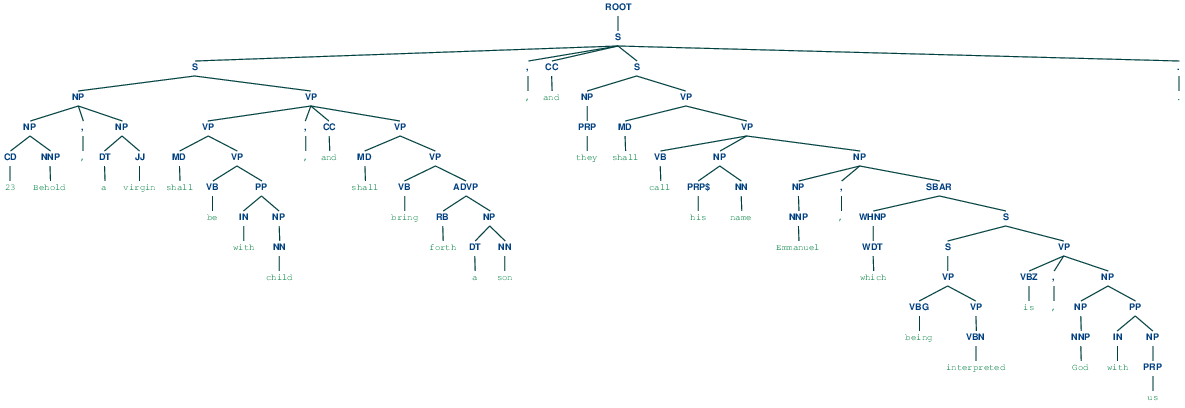

In [68]:
from IPython.display import Image
Image("output.png")

### Using jacardian index for initial filtering

In [73]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')
stopwords.append('thou')

In [76]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

In [81]:
def jacardScore(a, b):
    tokens_a = [token.lower().strip(string.punctuation) for token in tokenizer.tokenize(a) if token.lower().strip(string.punctuation) not in stopwords]
    tokens_b = [token.lower().strip(string.punctuation) for token in tokenizer.tokenize(b) if token.lower().strip(string.punctuation) not in stopwords]
    ratio = len(set(tokens_a).intersection(tokens_b)) / float(len(set(tokens_a).union(tokens_b)))
    return ratio

In [70]:
potential="./potential/"
booksList=os.listdir(potential)

In [71]:
test="./new/matthew"
testB=open(test)
raw=testB.read()
text = strip_headers(raw).strip()
text=text.replace('\n',' ')
text=text.replace(':','. ')
text=sent_tokenize(text)
text = list(filter(lambda x: len(x)>5, text))

In [85]:
books=dict()
for file in booksList:
    print(file)
    candidate=open(potential+file)
    rawtext=candidate.read()
    rawtext = strip_headers(rawtext).strip()
    candidate=rawtext.replace('\n',' ')
    candidate=rawtext.replace(':','. ')
    candidate=sent_tokenize(candidate)
    candidate = list(filter(lambda x: len(x)>5, candidate))
    books[file]=candidate

isaiah.txt
micah.txt


In [109]:
jacardScores=[]
for i in range(len(text)):
    scoresDict={}
    for book in booksList:
        bookScore=[]
        for k in range(len(books[book])):
            simScore=jacardScore(text[i], books[book][k])
            bookScore.append((simScore,k))
        scoresDict[book]=bookScore
    jacardScores.append(scoresDict)
        

In [110]:
for sent in jacardScores:
    for book in booksList:
        sent[book]=list(filter(lambda tup: tup[0]>0.12,sent[book]))

In [111]:
reducedSentences=dict()
for book in booksList:
    reducedSentences[book]=list()

In [112]:
for sent in jacardScores:
    for book in booksList:
        reducedSentences[book]=reducedSentences[book]+[x[1] for x in sent[book]]

In [113]:
for book in booksList:
    reducedSentences[book]=list(set(reducedSentences[book]))

In [114]:
len(reducedSentences['isaiah.txt'])

302